## How to work with SSM products: From download to visualization

Examples of downloading, reading and displaying SSM data in python are presented

* Download data from the H SAF FTP
* Move the data into the correct location
* Read H SAF SSM NRT/CDR data
* Visualize H SAF SSM NRT/CDR data on maps
* Extract spatial subsets  
* Performing basic statistical analysis

## Data download from H SAF FTP

```
ftp ftphsaf.meteoam.it
Connected to ftphsaf.meteoam.it.
220 Welcome to Italian Air Force Meteorological Service H-SAF FTP service.
username: <your_username>
password: <your_password>
Using binary mode to transfer files.
ls
229 Entering Extended Passive Mode (|||53635|).
150 Here comes the directory listing.
drwxr-xr-x   31 ftp      ftp          4096 Sep 20 03:14 hsaf_archive
dr-xr-xr-x   15 ftp      ftp          4096 Jun 11 08:25 hsaf_doc
dr-xr-xr-x    9 ftp      ftp          4096 Jul 02 12:41 hsaf_share
dr-xr-xr-x   46 ftp      ftp          4096 Feb 28  2019 products
226 Directory send OK.
cd products/h16/h16_cur_mon_data
exit
```

## Download, read and visualize ASCAT NRT SSM

### Read H16 - Metop-B ASCAT SSM NRT 12.5 km sampling

### The products H16, H101, H102, H103 come in the same BUFR format

* H16 - ascat.h_saf.H16img
* H101 - ascat.h_saf.H101img
* H102 - ascat.h_saf.H102img
* H103 - ascat.h_saf.H103img


### Read H16 - Metop-B ASCAT SSM NRT 12.5 km sampling

In [2]:
import os
import numpy as np
from datetime import datetime
import cartopy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.basemap import Basemap
import pytesmo.grid.resample as resample
import pytesmo.colormaps.load_cmap as smcolormaps
import ascat.h_saf as h_saf
#Run the H16 - Metop-B ASCAT SSM orbit geometry 12.5 km sampling
test_data_path = os.path.join('test_data', 'hsaf')
h16_path = os.path.join(test_data_path, 'h16')
h16_reader = h_saf.H16img(h16_path, month_path_str='')
# the reader returns not only the data but also metadata, longitudes and latitudes
h16_data, metadata, timestamp, lons, lats, time_var = h16_reader.read(datetime(2017, 2, 20, 11, 15, 0))
print(timestamp.isoformat())
print(type (h16_data))
# the data is a dictionary, each dictionary key contains the array of one variable
print("The following variables are in this image", h16_data.keys())
print(h16_data['Surface Soil Moisture (Ms)'].shape)
print( lons.shape )
print( lats.shape )

2017-02-20T11:15:00
<class 'dict'>
The following variables are in this image dict_keys(['Satellite Identifier', 'Direction Of Motion Of Moving Observing Platform', 'Orbit Number', 'Cross-Track Cell Number', 'f_Beam Identifier', 'f_Radar Incidence Angle', 'f_Antenna Beam Azimuth', 'f_Backscatter', 'f_Radiometric Resolution (Noise Value)', 'f_ASCAT KP Estimate Quality', 'f_ASCAT Sigma-0 Usability', 'f_ASCAT Land Fraction', 'm_Beam Identifier', 'm_Radar Incidence Angle', 'm_Antenna Beam Azimuth', 'm_Backscatter', 'm_Radiometric Resolution (Noise Value)', 'm_ASCAT KP Estimate Quality', 'm_ASCAT Sigma-0 Usability', 'm_ASCAT Land Fraction', 'a_Beam Identifier', 'a_Radar Incidence Angle', 'a_Antenna Beam Azimuth', 'a_Backscatter', 'a_Radiometric Resolution (Noise Value)', 'a_ASCAT KP Estimate Quality', 'a_ASCAT Sigma-0 Usability', 'a_ASCAT Land Fraction', 'Surface Soil Moisture (Ms)', 'Estimated Error In Surface Soil Moisture', 'Backscatter', 'Estimated Error In Sigma0 At 40 Deg Incidence Ang

### Visualize H16 - Metop-B ASCAT SSM NRT 12.5 km sampling

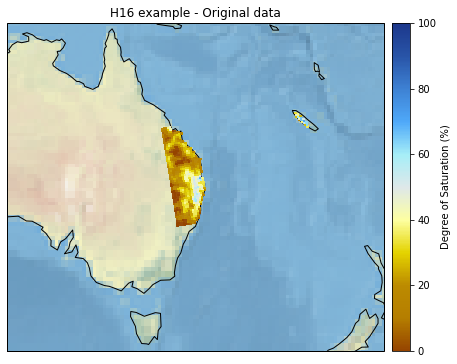

In [3]:
#Visualize H16 Metop-B ASCAT SSM NRT 12.5 km sampling
plot_crs = cartopy.crs.Mercator()
data_crs = cartopy.crs.PlateCarree()
fig = plt.figure(figsize=(7, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=plot_crs)
ax.set_title('H16 example - Original data')
ax.coastlines()
ax.stock_img()
#Subset of H16 Metop-B ASCAT SSM NRT 12.5 km sampling  product
ax.set_extent([130, 175, -10, -42])
data = h16_data['Surface Soil Moisture (Ms)']
data = np.ma.masked_where((data < 0) | (data > 100), data)
sc = ax.scatter(lons, lats, c=data, zorder=3, marker='s', s=2,
                transform=data_crs, cmap=smcolormaps.load('SWI_ASCAT'),
                vmin=0, vmax=100)
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cb1 = plt.colorbar(sc, cax=ax_cb)
cb1.set_label('Degree of Saturation (%)')
plt.show()

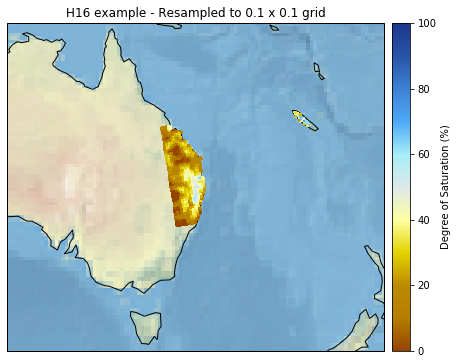

In [4]:
#Resampling to 0.1 degree grid
#Define the grid points in latitude and logitude
lats_dim = np.arange(-80, 80, 0.1)
lons_dim = np.arange(-160, 170, 0.1)
#make 2d grid out the 1D grid spacings
lons_grid, lats_grid = np.meshgrid(lons_dim, lats_dim)
resampled_data = resample.resample_to_grid(h16_data, lons, lats, lons_grid, lats_grid)
fig = plt.figure(figsize=(7, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=plot_crs)
ax.set_title('H16 example - Resampled to 0.1 x 0.1 grid')
ax.coastlines()
ax.stock_img()
ax.set_extent([130, 175, -10, -42])
data = resampled_data['Surface Soil Moisture (Ms)']
data[(data < 0) | (data > 100)] = np.nan
sc = ax.pcolormesh(lons_grid, lats_grid, data, zorder=3, cmap=smcolormaps.load('SWI_ASCAT'), vmin=0, vmax=100, transform=data_crs)
divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
fig.add_axes(ax_cb)
cb1 = plt.colorbar(sc, cax=ax_cb)
cb1.set_label('Degree of Saturation (%)')
plt.show()


## Download, read and visualize ASCAT SSM CDR

### Data download from H SAF FTP

```
ftp ftphsaf.meteoam.it
username: <your_username>
password: <your_password>
cd products/h113
exit
```

### Read H113 - Metop ASCAT SSM CDR 12.5km sampling

In [2]:
#Read H113 - Metop ASCAT SSM CDR 12.5 km sampling
import os
import ascat.h_saf as h_saf
import matplotlib
import matplotlib.pyplot as plt
test_data_path = os.path.join('test_data', 'hsaf')
h113_path = os.path.join(test_data_path, 'h113')
grid_path = os.path.join(test_data_path, 'grid')
static_layer_path = os.path.join(test_data_path, 'static_layer')
h113_reader = h_saf.H113Ts(h113_path, grid_path, static_layer_path=static_layer_path)


#### Grid point locator

CDR spatial sampling is defined by the WARP 5 grid, which represents a Discrete Global Grid
(DGG) with a fixed spacing of 12.5 km in longitudinal and latitudinal direction. The WARP 5
grid consists of 3264391 grid points, but only 839826 gird points are over land and can possibly
contain data. 

The location of the grid points are stored in an auxiliary file available on the
H SAF FTP (TUW_WARP5_grid_info_<version>.nc). An interactive tool, the so-called DGG
Point Locator3 can be used to search for specific grid points.

Grid points can be found using e.g. http://rs.geo.tuwien.ac.at/dv/dgg/

In [3]:
gpi = 2421579
h113_ts = h113_reader.read(gpi)
h113_reader.close()
#print((h113_ts.data))
print (h113_ts.data.head(3))


                            conf_flag  corr_flag  dir  proc_flag  sat_id  \
2007-01-01 19:24:41.270399          0          0    0          0       3   
2007-01-02 19:04:05.664000          0          0    0          0       3   
2007-01-03 20:23:26.217600          0          0    0          0       3   

                              sm  sm_noise  ssf  snow_prob  frozen_prob  \
2007-01-01 19:24:41.270399  52.0       4.0    1          0           64   
2007-01-02 19:04:05.664000  37.0       4.0    1         11           68   
2007-01-03 20:23:26.217600  45.0       4.0    1         11           68   

                            abs_sm_gldas  abs_sm_noise_gldas  abs_sm_hwsd  \
2007-01-01 19:24:41.270399           NaN                 NaN          NaN   
2007-01-02 19:04:05.664000           NaN                 NaN          NaN   
2007-01-03 20:23:26.217600           NaN                 NaN          NaN   

                            abs_sm_noise_hwsd  
2007-01-01 19:24:41.270399           

### Visualize H113 - Metop ASCAT SSM CDR 12.5km sampling

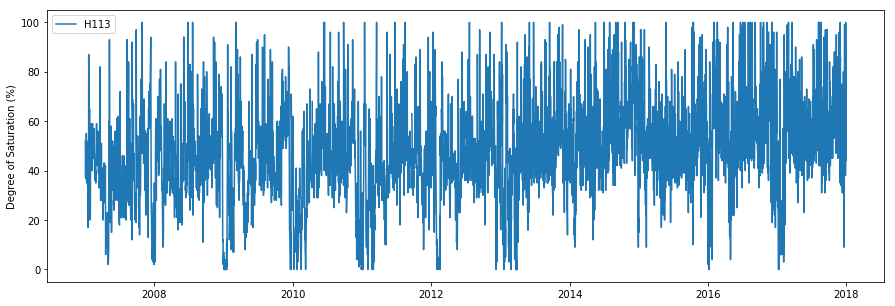

In [4]:
#show complete time series
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h113_ts.data['sm'], label='H113')
ax.set_ylabel('Degree of Saturation (%)')
ax.legend()
plt.show()

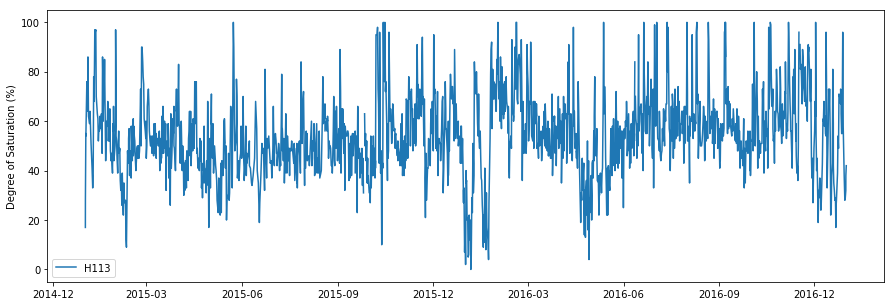

In [7]:
#show time series subset
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h113_ts.data['2015':'2016']['sm'], label='H113')
ax.set_ylabel('Degree of Saturation (%)')
ax.legend()

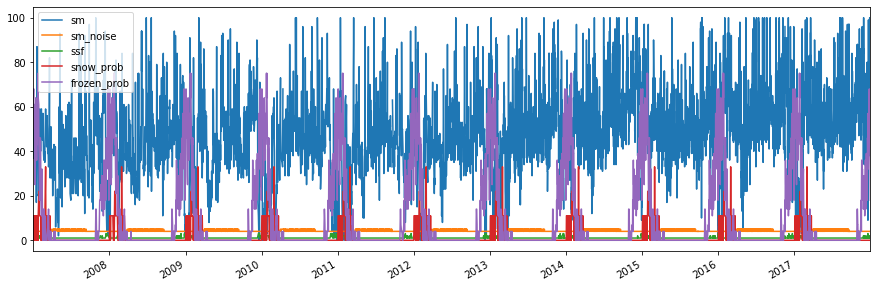

In [10]:
# Plot several variables stored in time series
h113_path = os.path.join(test_data_path, 'h113')
h113_reader = h_saf.H113Ts(h113_path, grid_path, static_layer_path=static_layer_path)
h113_ts = h113_reader.read(gpi)
fields = ['sm','sm_noise', 'ssf', 'snow_prob', 'frozen_prob']
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
h113_ts.data[fields].plot(ax=ax)
ax.legend()
plt.show()

### SSM CDR H113 can be extended using H114 SSM CDR-EXT 

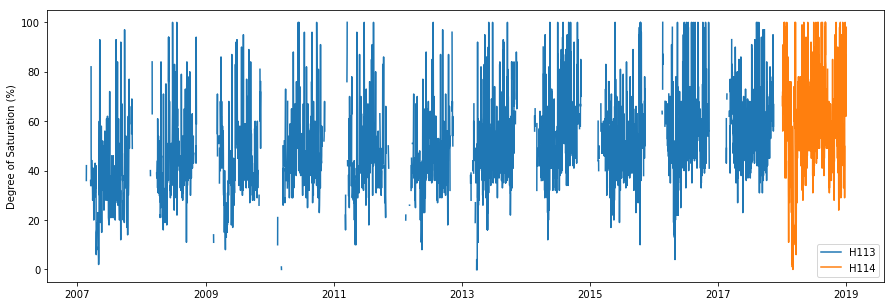

In [38]:
h114_path = os.path.join(test_data_path, 'h114')
h114_reader = h_saf.H114Ts(h114_path, grid_path, static_layer_path=static_layer_path)
h114_ts = h114_reader.read(gpi)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h113_ts.data['sm'], label='H113')
ax.plot(h114_ts.data['sm'], label='H114')
ax.set_ylabel('Degree of Saturation (%)')
ax.legend()
plt.show()

### Masking invalid soil moisture measurements

###  CDR product flags

Name Scaling_factor Units Type Byte_size NaN value
he product flags indicate various conditions of interest advising the user on the quality and
validity of the soil moisture observations. The flags provide an initial assistance on the usability
and shall not prevent the usage of external data sets for masking soil moisture observations

* SSF 
* CONF_FLAG 
* CORR_FLAG
* PROC_FLAG

Confidence flag meaning

* 1 Bad surface state flag
* 2 Topographic complexity > 50%
* 3 Wetland > 50%
* 4 Soil moisture noise > 50%
* 5 Sensitivity of soil moisture < 1 dB
* 6 Reserved for future use
* 7 Sensitivity of soil moisture < 1 dB
* 1-8 NaN



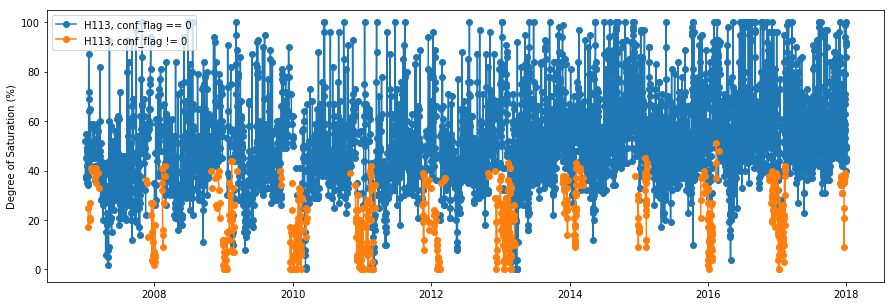

In [8]:
# show sm where 'conf_flag' != 0
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h113_ts.data.where(h113_ts.data['conf_flag'] == 0)['sm'], 
        marker='o', label='H113, conf_flag == 0')
ax.plot(h113_ts.data.where(h113_ts.data['conf_flag'] != 0)['sm'], 
        marker='o', label='H113, conf_flag != 0')
ax.set_ylabel('Degree of Saturation (%)')
ax.legend()

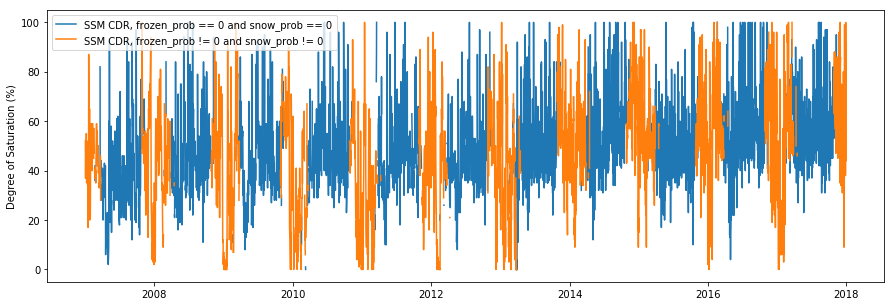

In [19]:
# show sm where 'frozen_prob' == 0
cdr_ts_masked = h113_ts.data
cdr_ts_masked['valid'] = False
cdr_ts_masked.loc[(h113_ts.data['frozen_prob'] == 0) & (h113_ts.data['snow_prob'] == 0), 'valid'] = True

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(cdr_ts_masked.where(cdr_ts_masked['valid'])['sm'], label='SSM CDR, frozen_prob == 0 and snow_prob == 0')
ax.plot(cdr_ts_masked.where(~cdr_ts_masked['valid'])['sm'], label='SSM CDR, frozen_prob != 0 and snow_prob != 0')
ax.set_ylabel('Degree of Saturation (%)')
ax.legend()

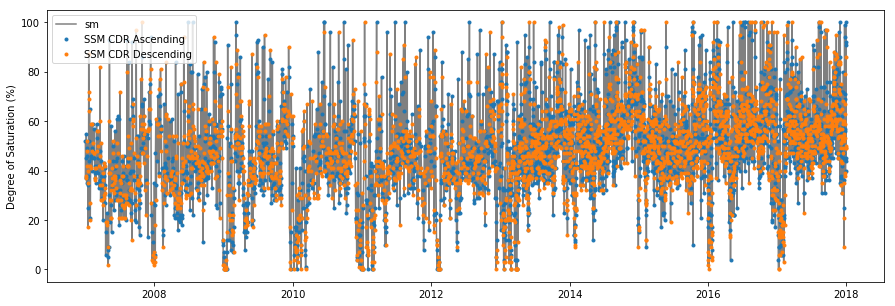

In [59]:
#show descending, ascending
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h113_ts.data['sm'], c='gray')
ax.plot(h113_ts.data['sm'].where(h113_ts.data['dir'] == 0), label='SSM CDR Ascending', ls='none', marker='.')
ax.plot(h113_ts.data['sm'].where(h113_ts.data['dir'] == 1), label='SSM CDR Descending', ls='none', marker='.')
ax.set_ylabel('Degree of Saturation (%)')
ax.legend()

### Differentiate between Metop-A and Metop-B soil moisture 

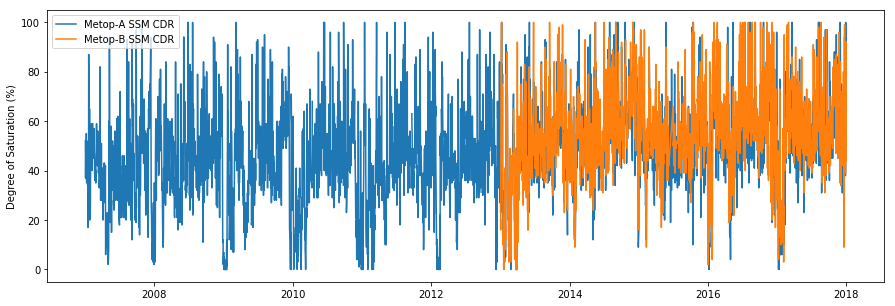

In [25]:
# show metop-a, metop-b
#Satellite sat_id The satellite id (SAT_ID) represents the sensor’s platform identification (Metop-A=3,Metop-B=4, Metop-C=5).
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h113_ts.data.loc[h113_ts.data['sat_id'] == 3, 'sm'], label='Metop-A SSM CDR')
ax.plot(h113_ts.data.loc[h113_ts.data['sat_id'] == 4, 'sm'], label='Metop-B SSM CDR')
ax.set_ylabel('Degree of Saturation (%)')
ax.legend()

2007-02-15 20:34:22.512000    45.0
2007-02-18 09:46:20.611200    47.0
2007-02-21 08:44:20.659200    36.0
2007-02-21 20:10:07.536000    42.0
2007-03-03 08:37:31.900800    48.0
2007-03-08 08:34:05.664000    56.0
2007-03-17 20:13:48.720000    36.0
2007-03-18 08:27:15.004800    34.0
2007-03-20 09:26:00.038400    82.0
2007-03-20 19:11:44.966400    48.0
2007-03-21 20:31:11.222400    34.0
2007-03-25 19:08:20.630400    44.0
2007-03-26 20:27:44.985600    38.0
2007-03-28 08:20:22.531200    34.0
2007-03-29 09:39:48.787200    28.0
2007-03-29 19:25:33.715200    29.0
2007-03-30 19:04:56.208000    33.0
2007-03-31 20:24:18.748800    36.0
2007-04-01 08:37:45.033600    41.0
2007-04-03 09:36:24.364800    36.0
2007-04-04 19:01:33.772800    20.0
2007-04-05 20:20:52.512000    28.0
2007-04-06 08:34:18.710400    26.0
2007-04-07 09:53:35.635200    39.0
2007-04-08 09:33:00.028800    29.0
2007-04-08 19:18:45.043200    30.0
2007-04-10 20:17:26.275200    38.0
2007-04-11 08:30:52.473600    30.0
2007-04-12 09:50:11.

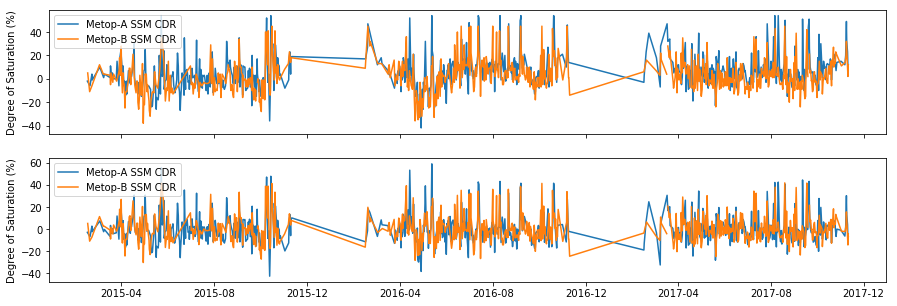

In [39]:
#Calculates the anaomaly of time series 

from pytesmo.time_series.anomaly import calc_anomaly

mask = (h113_ts.data['frozen_prob'] > 0) | (h113_ts.data['snow_prob'] > 0)
h113_ts.data = h113_ts.data.mask(mask)

ssm_a = h113_ts.data.loc[h113_ts.data['sat_id'] == 3, 'sm']
ssm_b = h113_ts.data.loc[h113_ts.data['sat_id'] == 4, 'sm']

ssm_a_anom = calc_anomaly(h113_ts.data.loc[h113_ts.data['sat_id'] == 3, 'sm'])
ssm_b_anom = calc_anomaly(h113_ts.data.loc[h113_ts.data['sat_id'] == 4, 'sm'])

print ssm_a
print ssm_b

#plot anomaly
fig, ax = plt.subplots(2, 1, figsize=(15, 5), sharex=True)

ax[0].plot(ssm_a['2015':] - ssm_a.median(), label='Metop-A SSM CDR')
ax[0].plot(ssm_b['2015':] - ssm_b.median(), label='Metop-B SSM CDR')
ax[0].set_ylabel('Degree of Saturation (%)')
ax[0].legend()

ax[1].plot(ssm_a_anom['2015':], label='Metop-A SSM CDR')
ax[1].plot(ssm_b_anom['2015':], label='Metop-B SSM CDR')
ax[1].set_ylabel('Degree of Saturation (%)')
ax[1].legend()

### SSM CDR H113 can be extended using H114 SSM CDR-EXT 

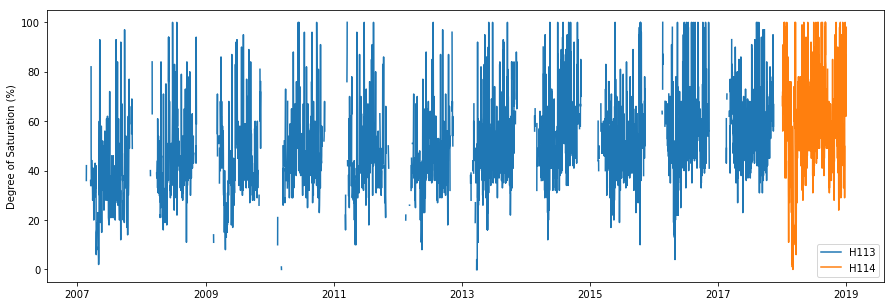

In [40]:
h114_path = os.path.join(test_data_path, 'h114')
h114_reader = h_saf.H114Ts(h114_path, grid_path, static_layer_path=static_layer_path)
h114_ts = h114_reader.read(gpi)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h113_ts.data['sm'], label='H113')
ax.plot(h114_ts.data['sm'], label='H114')
ax.set_ylabel('Degree of Saturation (%)')
ax.legend()
plt.show()

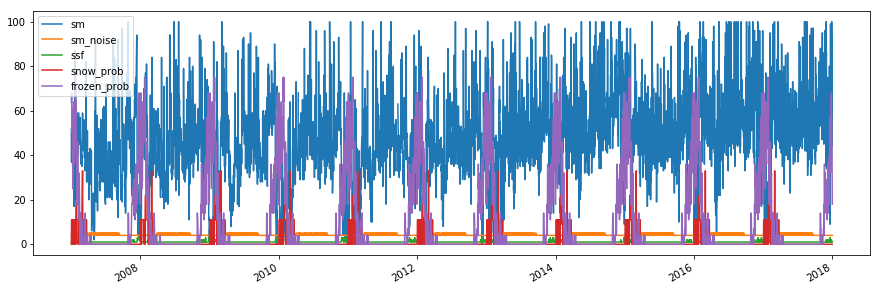

In [41]:
# Plot several variables stored in time series
h113_path = os.path.join(test_data_path, 'h113')
h113_reader = h_saf.H113Ts(h113_path, grid_path, static_layer_path=static_layer_path)
h113_ts = h113_reader.read(gpi)
fields = ['sm','sm_noise', 'ssf', 'snow_prob', 'frozen_prob']
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
h113_ts.data[fields].plot(ax=ax)
ax.legend()
plt.show()

### Convert to absolute surface soil moisture

It is possible to convert relative surface soil moisture given in degree of saturation into absolute soil moisture (m^3 m^{-3}) using the absolute_sm keyword during reading. Porosity information provided by NOAH GLDAS and pre-computed porosity from the Harmonized World Soil Database (HWSD) using the formulas of Saxton and Rawls (2006) is used to produce volumetric surface soil moisture

http://www.fao.org/soils-portal/soil-survey/soil-maps-and-databases/harmonized-world-soil-database-v12/en/

https://dl.sciencesocieties.org/publications/sssaj/abstracts/70/5/1569

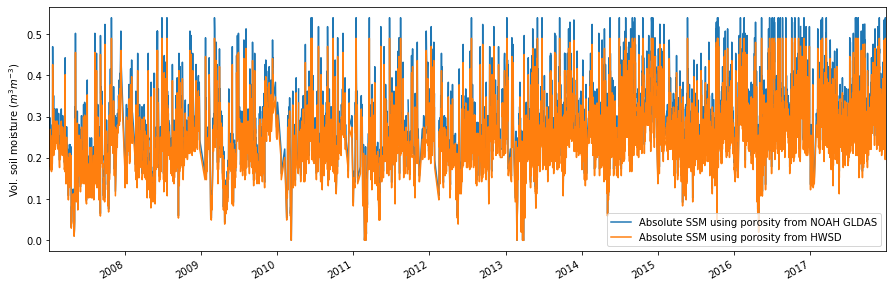

In [15]:

#Convert to absolute surface soil moisture
#Convert relative surface soil moisture in degree of saturation into absolute soil moisture
#Porosity information provided by NOAH GLDAS and precomputed porosity from the HWSD
h113_ts = h113_reader.read(gpi, absolute_sm=True)
conf_flag_ok = h113_ts.data['conf_flag'] == 0
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
h113_ts.data[conf_flag_ok]['abs_sm_gldas'].plot(ax=ax, label='Absolute SSM using porosity from NOAH GLDAS')
h113_ts.data[conf_flag_ok]['abs_sm_hwsd'].plot(ax=ax, label='Absolute SSM using porosity from HWSD')
ax.set_ylabel('Vol. soil moisture ($m^3 m^{-3}$)')
ax.legend()
plt.show()
